#Capítulo B - Background

## Setup

In [1]:
import numpy as np
import sympy as sym
import scipy
from IPython.display import display, Math
import matplotlib.pyplot as plt

In [2]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '18px'
      break
    }
  }
  '''))

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Arc
from matplotlib.transforms import Bbox, IdentityTransform, TransformedBbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

##Exemplo B.1

Determine os seguintes números na forma polar:

$
a)\:2 + j3
\\b) -2 + j1
\\c) -2 - j3
\\d)\:1 - j3
$

In [ ]:
def exampleb1(real, imag):
  a = real + imag * 1j # 2 + 3j
  mod_a = sym.sqrt((real**2 + imag**2))
  theta = np.rad2deg(np.arctan2(imag, real))

  increase_font()
  display(Math('z = %d + %dj = %s e^{j%s\degree}' %(real, imag, sym.latex(mod_a), round(theta, 2))))
  print('\n')
  plt.plot(real, imag, 'ro')
  plt.axis('square')
  plt.xlim([-5,5])
  plt.ylim([-5,5])
  plt.grid()
  axis = plt.gca()
  plt.plot([0, real], [0, imag], 'r')
  plt.plot(axis.get_xlim(),[0,0],'k--')
  plt.plot([0,0],axis.get_ylim(),'k--')
  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

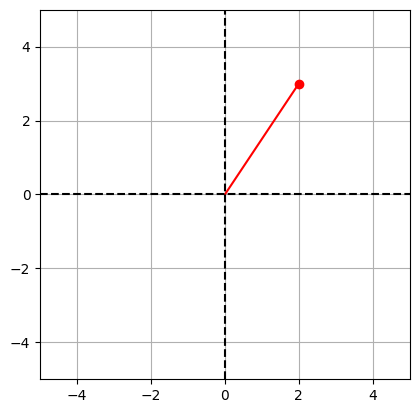

In [ ]:
real = 2
imag = 3
exampleb1(real, imag)

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

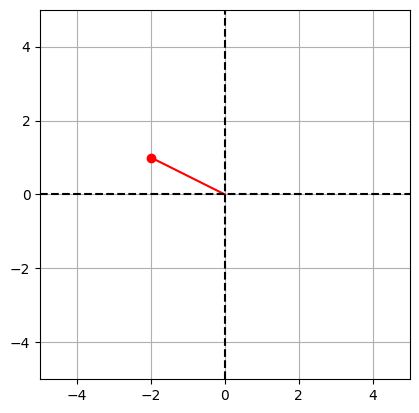

In [ ]:
real = -2
imag = 1
exampleb1(real, imag)

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

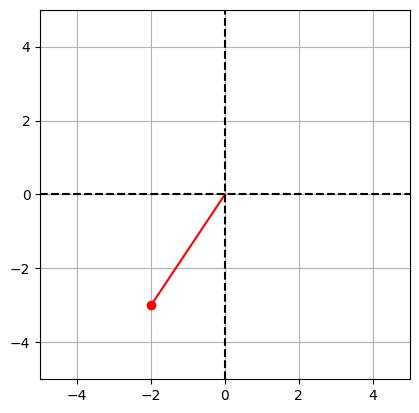

In [ ]:
real = -2
imag = -3
exampleb1(real, imag)

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

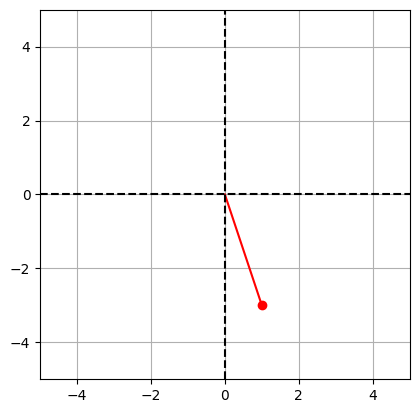

In [ ]:
real = 1
imag = -3
exampleb1(real, imag)

##Exemplo de Computador CB.1

Usando a função cart2poldo MATLAB, converta os seguintes números da forma Cartesiana para a for
ma polar:

$
\:(a)\:z = 2 + 3 \\
\:(b)\:z = -2 + j
$

In [ ]:
az = 2 + 3j
bz = -2 + 1j

azmag = np.abs(az)
azrad = np.angle(az)
azdeg = np.angle(az, deg=True)

bzmag = np.abs(bz)
bzrad = np.angle(bz)
bzdeg = np.angle(bz, deg=True)

display(Math('z = 2 + 3j = %s e^{j%s} = %s e^{j%s}' %(round(azmag,4), round(azrad,2), round(azmag,4), round(azdeg,2))))
display(Math('z = -2 + 1j = %s e^{j%s} = %s e^{j%s}' %(round(bzmag,4), round(bzrad,2), round(bzmag,4), round(bzdeg,2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Exemplo B.2

Represente os seguintes números no plano complexo e expresse-os na forma Cartesiana:

$
(a)\:2e^{j\pi/3}\\
(b)\:4e^{-j3\pi/4}\\
(c)\:2e^{j\pi/2}\\
(d)\:3e^{-j3\pi}\\
(e)\:2e^{j4\pi}\\
(f)\:2e^{-j4\pi}\\
$

$r(\cos{\theta} + j \sin{\theta})$

In [ ]:
def exampleb2(mod, angle, xlim=[-5,5], ylim=[-5,5]):
  result = mod*(sym.cos(angle) + sym.sin(angle) * 1j)
  l_angle = sym.latex(angle)
  increase_font()
  signal = '+' if angle.is_positive else '-'
  display(Math('%s e^{i%s} = %s(\cos{%s} %s i \sin{%s}) = %s' %(mod, l_angle, mod, l_angle, signal, l_angle, sym.latex(result))))
  real, imag = result.as_real_imag()
  print('\n')
  fig, ax = plt.subplots()
  ax.plot(real, imag, 'ro')
  ax.text(real + 0.1, imag, '$%s e^{j \\ %s}$' %(mod, l_angle), fontsize=12)
  am1 = AngleAnnotation((0,0), [float(real), 0], [float(real), float(imag)], ax=ax, size=75, text=rf"${l_angle}$")
  ax.plot(0, )
  ax.axis('square')
  plt.xlabel('Real')
  plt.ylabel('Imag')
  plt.xlim(xlim)
  plt.ylim(ylim)
  ax.grid()
  axis = plt.gca()
  ax.plot([0, real], [0, imag], 'r', linewidth=2.5)
  ax.plot(axis.get_xlim(),[0,0],'k--')
  ax.plot([0,0],axis.get_ylim(),'k--')
  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

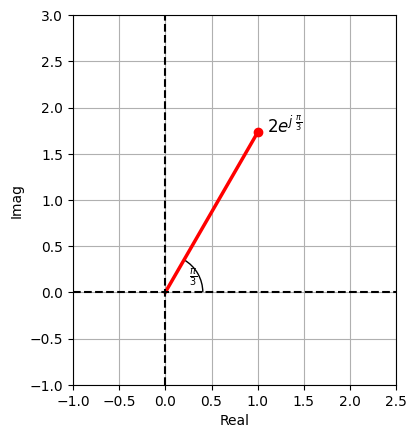

In [ ]:
exampleb2(2, sym.pi/3, xlim=[-1,2.5], ylim=[-1,3])

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

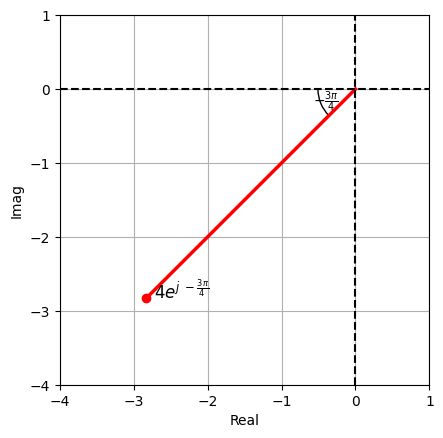

In [ ]:
exampleb2(4, -3*sym.pi/4, xlim=[-4,1], ylim=[-4,1])

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

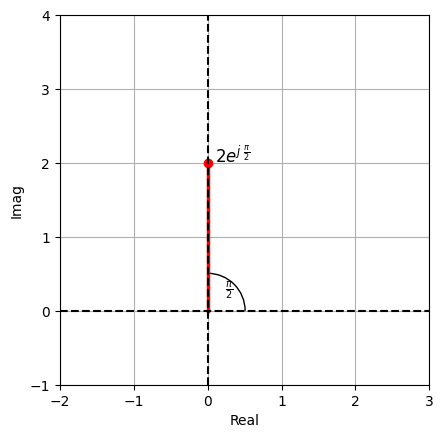

In [ ]:
exampleb2(2, sym.pi/2, xlim=[-2,3], ylim=[-1,4])

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

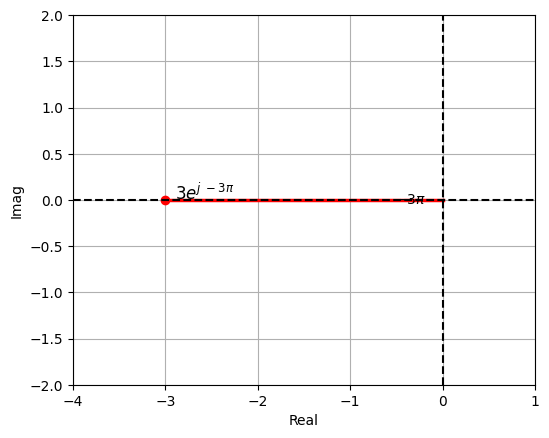

In [ ]:
exampleb2(3, -3*sym.pi, xlim=[-4,1], ylim=[-2,2])

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

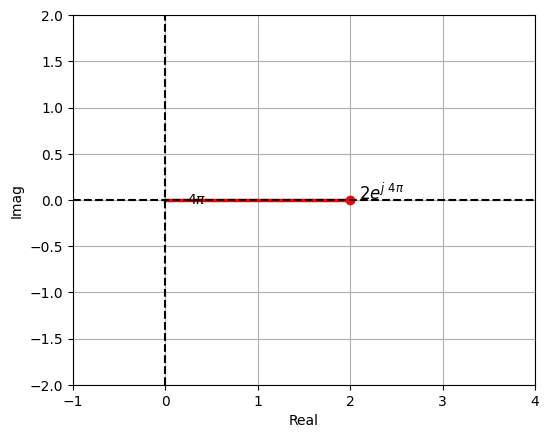

In [ ]:
exampleb2(2, 4*sym.pi, xlim=[-1,4], ylim=[-2,2])

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

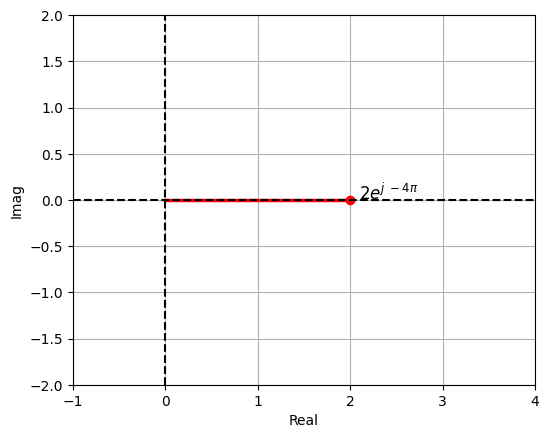

In [ ]:
exampleb2(2, -4*sym.pi, xlim=[-1,4], ylim=[-2,2])

## EXEMPLO DE COMPUTADOR CB.2

Usando a função pol2cart do MATLAB, converta o número $z=4e^{–j(3π/4)}$ da forma polar para a forma Cartesiana.

In [8]:
def cart2pol(x, y):
    rho = np.sqrt((x**2 + y**2))
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

z_real, z_imag = pol2cart(4, -3*np.pi/4)
display(Math('z = 4e^{-j3\pi/4} = %s %sj' %(round(z_real,4), round(z_imag,4))))

<IPython.core.display.Math object>

## Exemplo B.3

Determine $z_1 z_2$ e $z_1/z_2$ para os números

> $
z_1 = 3 + j4 = 5e^{j53,1 °}\\
z_2 = 2 + j3 = \sqrt{13}e^{j56,3 °}
$

Nós devemos resolver este problema tanto na forma polar quanto na forma cartesiana.

In [10]:
z1 = 3 + 4j
z2 = 2 + 3j

z1divz2 = z1/z2
z1divz2 = round(z1divz2.real, 2) + round(z1divz2.imag, 2) * 1j

increase_font()
display(Math('z_1 z_2 = %s %s = (6-12) + j(8+9) = %s' %(z1, z2, z1*z2)))
print('\n')
display(Math('\\frac{z_1}{z_2} = \\frac{%s}{%s} = \\frac{%s%s}{%s%s} = \\frac{%s}{2^2 + 3^2} = \\frac{%s}{13} = \\frac{18}{13} - j\\frac{1}{13} = %s' %(z1, z2, z1, np.conj(z2), z2, np.conj(z2), z1*np.conj(z2), z1*np.conj(z2), z1divz2)))

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
def cart2pol(z, deg=False):
  mag = np.abs(z)
  angle = np.angle(z, deg=deg)
  return (mag, angle)
z1mag, z1angle  = cart2pol(z1, True)
z2mag, z2angle = cart2pol(z2, True)

increase_font()
display(Math('z_1z_2 = (%se^{j%s\degree})(\sqrt{13}e^{j%s\degree}) = 5\sqrt{13}e^{j%s\degree}' %(z1mag, round(z1angle, 2), round(z2angle, 2), round(z1angle+z2angle,2))))
print('\n')
display(Math('\\frac{z_1}{z_2} = \\frac{%se^{j%s}}{\sqrt{13}e^{j%s}} = \\frac{%s}{\sqrt{13}} e^{j%s\degree - %s\degree} = \\frac{%s}{\sqrt{13}} e^{j%s\degree}'
                                    %(z1mag, round(z1angle, 2), round(z2angle, 2), z1mag, round(z1angle, 2), round(z2angle, 2), z1mag, round(z1angle-z2angle,2))))

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Exemplo B.4

Para $z_1 = 2e^{j\pi/4}$ e $z_2 = 8e^{j\pi/3}$ determine:

(a) $2z_1 - z_2$

(b) $1/z_1$

(c) $\frac{z_1}{z^2_2}$

(d) $ \sqrt[3]{z_2}$

In [ ]:
def pol2cart(rho, phi):
    x = rho * sym.cos(phi)
    y = rho * sym.sin(phi)
    return (x,y)

z1 = pol2cart(2, sym.pi/4)
z2 = pol2cart(8, sym.pi/3)

display(Math('z_1 = %s + j%s' %(sym.latex(z1[0]), sym.latex(z1[1]))))
display(Math('z_2 = %s + j%s' %(sym.latex(z2[0]), sym.latex(z2[1]))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
display(Math('(a) 2z_1 - z_2 = %s = %s' %(sym.latex((2 * z1[0] + complex(0,1) * z1[1]) - z2[0] + complex(0,1) * z2[1]),sym.latex(2 * complex(z1[0], z1[1]) - complex(z2[0], z2[1])))))

<IPython.core.display.Math object>

In [ ]:
display(Math('(b) \\ \\frac{1}{z_1} = %s = %s' %(sym.latex(1 / (2*sym.exp(complex(0,1) * sym.pi / 4))),1 / complex(z1[0], z1[1]))))

<IPython.core.display.Math object>

In [ ]:
display(
    Math(
        '(c) \\ \\frac{z_1}{z^2_2} = %s = %s'
        %(
          sym.latex(2*sym.exp(complex(0,1) * sym.pi/ 4)/(8 * sym.exp(complex(0,1) * sym.pi/3))**2),
          sym.latex(complex(z1[0], z1[1])/complex(z2[0], z2[1]))
          )
        )
    )

<IPython.core.display.Math object>

In [ ]:
result = complex(z2[0], z2[1])**(1/3)
result_pol = cart2pol(result.real, result.imag)
display(
    Math(
        '(c) \\ \\sqrt[3]{z_2} = %s = %s'
        %(
            sym.latex(sym.cbrt(complex(z2[0], z2[1]))),
            sym.latex(result_pol[0] * sym.exp(result_pol[1] * complex(0,1)))
        )
    )
)

<IPython.core.display.Math object>

## Exemplo de Computador CB.3

Determine $z_1z_2$ e $z_1/z_2$ se:
> $z_1 = 3 + j4 \\ z_2 = 2 + j3$

In [ ]:
z1 = 3 + 4j
z2 = 2 + 3j

In [ ]:
display(Math('z_1z_2 = %s' %(z1*z2)))

<IPython.core.display.Math object>

In [ ]:
display(Math('\\frac{z_1}{z_2} = %s = %s' %(sym.latex(sym.sympify(z1)/sym.sympify(z2)),z1/z2)))

<IPython.core.display.Math object>

## Exemplo B.5 (TODO Corrigir)

Considere $X(𝜔)$ uma função complexa de uma variável real $𝜔$ :

> $X(𝜔) = \frac{2 + j\omega}{3 + j4\omega}$

(a) Determine $X(ω)$ na forma Cartesiana e determine sua parte real e imaginária

(b) Determine $X(ω)$ na forma Polar e determine seu módulo $|X(ω)|$ e seu ângulo $X(ω)$.



In [ ]:
w = sym.Symbol('w', real=True)
z1 = 2 + (w * 1j)
z2 = 3 + (w * 4j)
display(Math('X(\omega) = \\frac{%s}{%s}' %(sym.latex(z1), sym.latex(z2))))

<IPython.core.display.Math object>

In [ ]:
display(Math('\\frac{%s}{%s}' %(sym.latex(z1 * sym.conjugate(z2)), sym.latex(z2 * sym.conjugate(z2)))))

<IPython.core.display.Math object>

In [ ]:
sym.simplify(z2 * sym.conjugate(z2))

16.0*w**2 + 9.0

In [ ]:
sym.simplify(z1 * sym.conjugate(z2)) / sym.simplify(z2 * sym.conjugate(z2))

(4.0*w**2 - 5.0*I*w + 6.0)/(16.0*w**2 + 9.0)

In [ ]:
sym.expand(sym.simplify(z1 * sym.conjugate(z2)) / sym.simplify(z2 * sym.conjugate(z2)))

4.0*w**2/(16.0*w**2 + 9.0) - 5.0*I*w/(16.0*w**2 + 9.0) + 6.0/(16.0*w**2 + 9.0)

## Exemplo B.6

Nos casos a seguir, exprese $x(t)$ como uma única senoide:

$(a) \ x(t) = \cos{ω_ot} - - \sqrt{3}\sin{ω_ot} \\
(b) \ x(t) = -3 \cos{ω_ot} + 4 \sin{ω_ot}$

Utilize as equações:

$(B.23a) \ C \cos(ω_ot + θ) = C \cos θ \cos{ω_ot} - C \sin θ \sin{ω_ot} = a \cos{ω_ot} + b \sin{ω_ot} $

onde: $a = C \cos{θ}$ e $b = -C \sin{θ}$

$(B.23b) \ C = \sqrt{a^2 + b^2} $

$(B.23c) \ θ = \tan^{-1}{(\frac{-b}{a})} $

In [ ]:
def graph_reta(ax, real, imag, xlim=[-2,2], ylim=[-2,2]):
  ax.arrow(0, 0, 0, imag, head_width = 0.1,  head_length = 0.1, linewidth=3)
  ax.arrow(0, 0, real, 0, head_width = 0.1,  head_length = 0.1, linewidth=3)
  ax.arrow(0, 0, real, imag, head_width = 0.1,  head_length = 0.1, linewidth=3)
  AngleAnnotation((0,0), [float(real), 0], [float(real), float(imag)], ax=ax, size=75, text=rf"${float(theta * 180/sym.pi)}°$")
  ax.axis('square')
  plt.xlabel('Real')
  plt.ylabel('Imag')
  plt.xlim(xlim)
  plt.ylim(ylim)
  ax.grid()
  axis = plt.gca()

### (a)

In [ ]:
real = 1
imag = sym.sqrt(3)

C = sym.sqrt(real ** 2 + imag ** 2)
display(Math("C = \sqrt{%s^2 + (%s)^2} = %s" %(real, sym.latex(imag), C)))

print("\n")

theta = sym.atan(imag/real)
display(Math(" \\theta =\\tan^{-1}{(\\frac{%s}{%s})} = %s = %s°" %(sym.latex(imag), real, sym.latex(theta), theta * 180/sym.pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

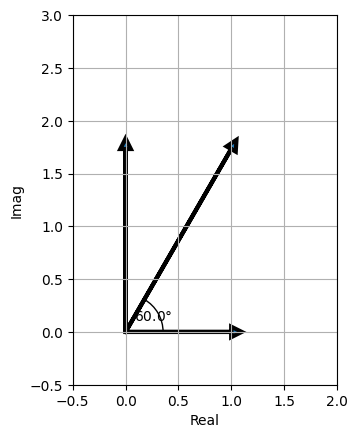

In [ ]:
fig, ax = plt.subplots()
graph_reta(ax, real, float(imag), xlim=[-0.5, 2], ylim=[-0.5, 3])

### (b)

In [ ]:
real = -3
imag = -4

C = sym.sqrt(real ** 2 + imag ** 2)
display(Math("C = \sqrt{%s^2 + (%s)^2} = %s" %(real, imag, C)))

print("\n")

theta = sym.atan(imag/real)
display(Math(" \\theta =\\tan^{-1}{(\\frac{-%s}{%s})} = %s = %s°" %(imag, real, sym.latex(theta), float(theta * 180/sym.pi))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

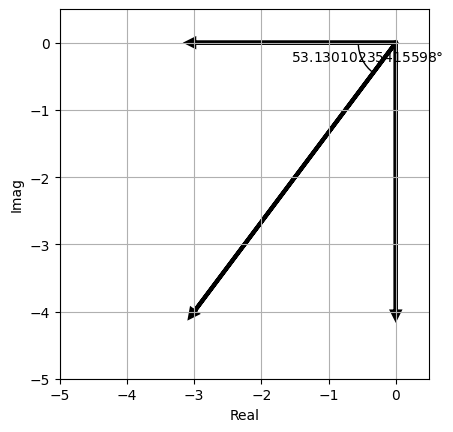

In [ ]:
fig, ax = plt.subplots()
graph_reta(ax, float(real), float(imag), xlim=[-5, 0.5], ylim=[-5, 0.5])

## Exemplo de Computador CB.4

Expresse $f(t) = -3\cos(ω_ot) + 4\sin(ω_ot)$ como uma única senoide.

In [ ]:
real = -3
imag = 4

C = sym.sqrt(real ** 2 + imag ** 2)
display(Math("C = \sqrt{%s^2 + (%s)^2} = %s" %(real, sym.latex(imag), C)))

print("\n")

theta = sym.atan(imag/real)
display(Math(" \\theta =\\tan^{-1}{(\\frac{%s}{%s})} = %s = %s°" %(sym.latex(imag), real, sym.latex(theta), theta * 180/sym.pi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Exemplo B.7

Utilize a Regra de Cramer para resolver as seguintes equações lineares simultâneas com três incógnitas.

$2x_1 + x_2 + x_3 = 3\\
x_1 + 3x_2 - x_3 = 7\\
x_1 + x_2 + x_3 = 1$

In [ ]:
def simple_cramer(mat, constant):
    D = np.linalg.det(mat)
    mat1 = np.array([constant, mat[:, 1], mat[:, 2]])
    mat2 = np.array([mat[:, 0], constant, mat[:, 2]])
    mat3 = np.array([mat[:, 0], mat[:, 1], constant])
    Dx = np.linalg.det([mat1, mat2, mat3])
    X = Dx/D
    return X

In [ ]:
# https://www.computersciencemaster.com.br/como-resolver-um-sistema-de-equacoes-usando-python/
# https://stackoverflow.com/questions/70323836/solving-system-of-linear-equation-using-cramers-method-in-python
def complex_cramer(a, b):
  mask = np.broadcast_to(np.diag([1,1,1]), [3, 3, 3]).swapaxes(0, 1)
  Ms = np.where(mask, np.repeat(b, 3).reshape(3, 3), a)
  return np.linalg.det(Ms) / np.linalg.det(a)

In [ ]:
A = np.array([[2, 1, 1],
              [1, 3, -1],
              [1, 1, 1]])

B = np.array([3, 7, 1])

solution = simple_cramer(A, B)
display(Math("x_1 = %.1f \\ x_2 = %.1f \\ x_3 = %.1f" %(solution[0], solution[1], solution[2])))

<IPython.core.display.Math object>

## Exemplo B.8

Expanda a seguinte função racional $F(x)$ em frações parciais:

$F(x) = \frac{x^3 + 3x^2 + 4x + 6}{(x + 1)(x + 2)(x + 3)^2}$

In [ ]:
x = sym.Symbol("x")

numerador = x ** 3 + 3 * x ** 2 + 4 * x + 6
denominador = (x + 1) * (x + 2) * (x + 3) ** 2

G = numerador / denominador
sym.apart(G)

2/(x + 3) - 3/(x + 3)**2 - 2/(x + 2) + 1/(x + 1)

## Exemplo B.9

Expanda a seguinte função racional $F(x)$ em frações parciais:

$F(x) = \frac{2x^2 + 9x - 11}{(x + 1)(x - 2)(x + 3)}$

In [ ]:
x = sym.Symbol("x")

numerador = 2 * x ** 2 + 9 * x - 11
denominador = (x + 1) * (x - 2) * (x + 3)

G = numerador / denominador
sym.apart(G)

-2/(x + 3) + 3/(x + 1) + 1/(x - 2)

## Exemplo B.10

Expanda $F(x)$ em frações parciais se


<center> $\\F(x) = \frac{4x^3 + 16x^2 + 23x + 13}{(x + 1)^3(x + 2)}$</center>




In [ ]:
x = sym.Symbol("x")

numerador = 4 * x ** 3 + 16 * x ** 2 + 23 * x + 13
denominador = (x + 1) ** 3 * (x + 2)

G = numerador / denominador
sym.apart(G)

1/(x + 2) + 3/(x + 1) + (x + 1)**(-2) + 2/(x + 1)**3

## Exemplo B.11

Expanda $F(x)$ em frações parciais se


<center> $\\F(x) = \frac{3x^2 + 9x -20}{x^2 + x -6} = \frac{3x^2 + 9x -20}{(x-2)(x+3)}$</center>




In [ ]:
x = sym.Symbol("x")

numerador = 3*x**2 + 9*x -20
denominador = (x-2)*(x+3)

G = numerador / denominador
sym.apart(G)

3 + 4/(x + 3) + 2/(x - 2)

## Exemplo B.12

Vamos determinar $A^{-1}$ se

<center> $A = \begin{bmatrix}
2 & 1 & 1 \\
1 & 2 & 3 \\
3 & 2 & 1 \\
\end{bmatrix}$</center>

In [ ]:
# https://stackoverflow.com/questions/17129290/numpy-2d-and-1d-array-to-latex-bmatrix
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [ ]:
A = np.array([
    [2,1,1],
    [1,2,3],
    [3,2,1]
])

display(Math(bmatrix(np.linalg.inv(A))))


<IPython.core.display.Math object>

## Exemplo B.13

<center> $A = \begin{bmatrix}
0 & 1 \\
-2 & -3 \\
\end{bmatrix}$</center>

A equação característica é

<center> $\begin{bmatrix}
λ𝐈 - Α
\end{bmatrix} =
\begin{bmatrix}
λ & -1 \\
2 & λ + 3 \\
\end{bmatrix} = λ^2 + 3λ + 2 = (λ+1)(λ+2) = 0$</center>

Logo os autovalores são $λ_1 = -1, λ_2 = -2$, e

<center> $e^{At} = β_0𝐈 + β_1A$</center>

na qual

<center> $\begin{bmatrix}
β_0 \\
β_1
\end{bmatrix} =
\begin{bmatrix}
1 & -1\\
1 & -2
\end{bmatrix}^{-1}
\begin{bmatrix}
e^{-t} \\
e^{-2t}
\end{bmatrix} =
\begin{bmatrix}
2 & -1\\
1 & -1
\end{bmatrix}
\begin{bmatrix}
e^{-t} \\
e^{-2t}
\end{bmatrix} =
\begin{bmatrix}
2e^{-t} & -e^{-2t}\\
e^{-t} & -e^{-2t}
\end{bmatrix}
$</center>

e

<center> $e^{At} = (2e^{-t}-e^{-2t})\begin{bmatrix}1 & 0 \\ 0 & 1 \\\end{bmatrix} + (e^{-t}-e^{-2t})\begin{bmatrix}
0 & 1 \\
-2 & -3 \\
\end{bmatrix} = \begin{bmatrix}
2e^{-t}-e^{-2t} & e^{-t}-e^{-2t} \\
-2e^{-t}+2e^{-2t} & -e^{-t}+2e^{-2t} \\
\end{bmatrix}$</center>

## MB.2 Operações de Calculadora

In [ ]:
z = -3 -4j
z

(-3-4j)

In [ ]:
z_real, z_imag = z.real, z.imag
print(f"z_real: {z_real}")
print(f"z_imag: {z_imag}")

z_real: -3.0
z_imag: -4.0


In [ ]:
z_mag = np.sqrt(z_real**2 + z_imag**2)
z_mag

5.0

In [ ]:
z_mag = np.sqrt(z*np.conj(z))
z_mag

(5+0j)

In [ ]:
z_mag = np.abs(z)
z_mag

5.0

In [ ]:
z_rad = np.angle(z)
z_rad

-2.214297435588181

In [ ]:
z_deg = np.angle(z) * 180 / np.pi
z_deg

-126.86989764584402

In [ ]:
z_deg = np.angle(z, deg=True)
z_deg

-126.86989764584402

In [ ]:
z_rad = np.arctan2(z_imag, z_real)
z_rad

-2.214297435588181

In [ ]:
np.cos(1j)

(1.5430806348152437-0j)

In [ ]:
np.log(-1, dtype=complex)

3.141592653589793j

## MB.3 Operações Vetoriais

In [ ]:
k = np.arange(0,11,2)
k

array([ 0,  2,  4,  6,  8, 10])

In [ ]:
k = np.arange(11,0,-10/3)
k

array([11.        ,  7.66666667,  4.33333333,  1.        ])

In [ ]:
k = np.arange(0, 12)
k

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
k = np.arange(0,3)
w = np.exp(1j*(np.pi/3 + 2*np.pi*k/3))
w

array([ 0.5+8.66025404e-01j, -1. +1.22464680e-16j,  0.5-8.66025404e-01j])

In [ ]:
k = np.arange(0,100)
w = np.exp(1j*(np.pi/100 + 2*np.pi*k/100))

In [ ]:
# zero index
w[4]

(0.9602936856769431+0.2789911060392293j)

In [ ]:
k[4]

4

In [ ]:
w[97:100]

array([0.98768834-0.15643447j, 0.99556196-0.09410831j,
       0.99950656-0.03141076j])

In [ ]:
t = np.arange(0, 0.2-0.2/500, 0.2/500)

In [ ]:
f = np.sin(2*np.pi*10*t+np.pi/6)
f[0]

0.49999999999999994

## MB.4 Gráficos Simples

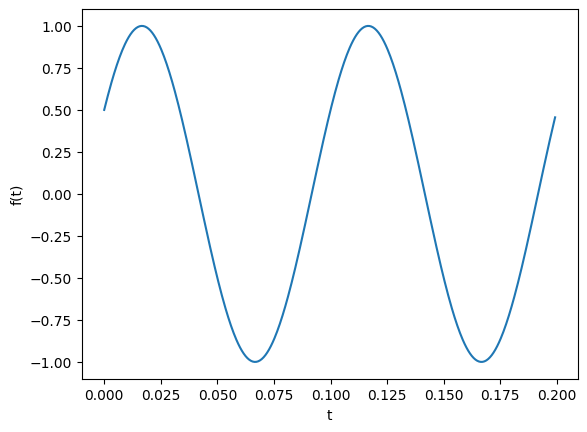

In [ ]:
plt.plot(t,f)
plt.xlabel('t')
plt.ylabel('f(t)')
plt.show()

$e^{\frac{2πj}{n}}$

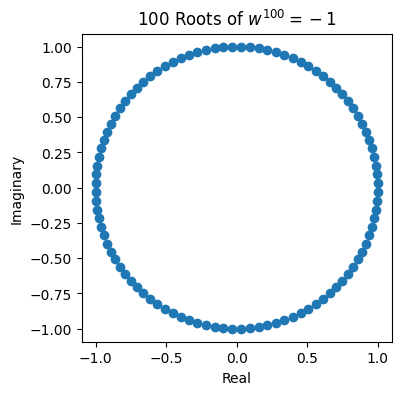

In [ ]:
roots = np.exp(1j * np.pi * (2 * np.arange(100) + 1) / 100)
plt.figure(figsize=(4, 4))
plt.scatter(roots.real, roots.imag)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.axis('equal')
plt.title('100 Roots of $w^{100} = -1$')
plt.show()

## MB.5 Operações de Elemento por Elemento

In [ ]:
# de exemplos anteriores
t = np.arange(0, 0.2-0.2/500, 0.2/500)
f = np.sin(2*np.pi*10*t+np.pi/6)

In [ ]:
g = np.exp(-10*t)

In [ ]:
h = f * g

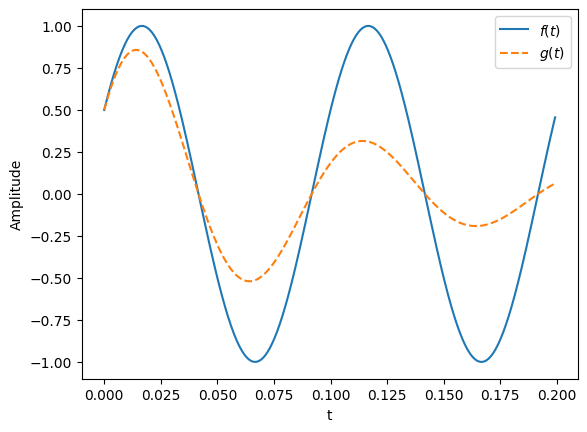

In [ ]:
plt.plot(t,f, label='$f(t)$')
plt.plot(t,h, '--', label='$g(t)$')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## MB.6 Operações Matriciais

In [ ]:
r = np.array([1,0,0])
r

array([1, 0, 0])

In [ ]:
A = np.array([[2,3],[4,5],[0,6]])
A

array([[2, 3],
       [4, 5],
       [0, 6]])

In [ ]:
c = r[...,np.newaxis]
c

array([[1],
       [0],
       [0]])

In [ ]:
B = np.concatenate([c, A], axis=1)
B

array([[1, 2, 3],
       [0, 4, 5],
       [0, 0, 6]])

In [ ]:
B[0,1]

2

In [ ]:
B[0:2,1:3]

array([[2, 3],
       [4, 5]])

In [ ]:
B[1,:]

array([0, 4, 5])

In [ ]:
A = np.array([[1,-2,3],[-np.sqrt(3), 1, -np.sqrt(5)],[3, -np.sqrt(7), 1]])
y = np.array([[1],[np.pi],[np.exp(1)]])

In [ ]:
x = np.linalg.lstsq(A,y, rcond=None)
x

(array([[-1.99989019],
        [-3.89977711],
        [-1.59988801]]),
 array([], dtype=float64),
 3,
 array([5.91269542, 2.10252927, 0.78702191]))

In [ ]:
x1 = np.linalg.det(np.concatenate([y, A[:, 1:3]], axis=1))/np.linalg.det(A)
x1

-1.9998901878846425

In [ ]:
alfa = np.arange(0,11)

In [ ]:
t = np.arange(0, 0.201, 0.001)

In [ ]:
T = np.outer(t, np.ones(11))

In [ ]:
H = np.exp(-T @ np.diag(alfa)) * np.sin(2 * np.pi * 10 * T + np.pi / 6)

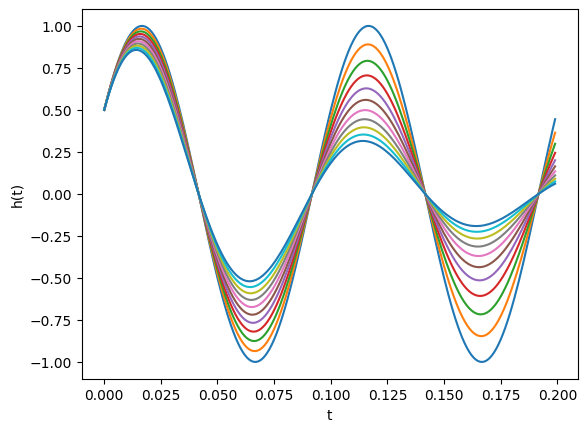

In [ ]:
plt.plot(t,H)
plt.xlabel('t')
plt.ylabel('h(t)')
plt.show()

## MB.7 Expansão em Frações Parciais

In [ ]:


[R, P, K] = scipy.signal.residue([1, 0, 0, 0, 0, np.pi], [1, -np.sqrt(8), 0, np.sqrt(32), -4], tol=0.001, rtype='avg')
print(f"R = {R}")
print(f"P = {P}")
print(f"K = {K}")

R = [0.11115991-0.j 7.88884009+0.j 5.97126195+0.j 3.11072073+0.j]
P = [-1.41421356+0.j  1.41421356+0.j  1.41421356+0.j  1.41421356+0.j]
K = [1.         2.82842712]


## Problemas

### B.1

Dado um número complexo $w = x + jy$, o complexo conjugado de w é definido em coordenadas retangulares como $w* = x – jy$. Use este fato para determinar o complexo conjugado na
forma polar.

In [7]:
from sympy.abc import x, y

w = x + 1j*y

# Calculate the magnitude
r = sym.sqrt(x**2 + y**2)

# Calculate the argument
theta = sym.exp(sym.I*sym.atan(y/x))
theta2 = sym.exp(-1*sym.I*sym.atan(y/x))

display(Math("%s = %s" %(sym.latex(w), sym.latex(r*theta))))
display(Math("%s = %s" %(sym.latex(sym.conjugate(w)), sym.latex(r*theta2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### B.2 Escreva os seguintes números na forma polar:

(a) $1 + j$

(b) $-4 + j3$

(c) $(j+1)(-4+j3)$

(d) $e^{jπ} + 2e^{-j\pi/4}$

(e) $e^j +  1$

(f) $1/2^j$

In [6]:
a = 1 + 1j

##Matlab Seção 1: Trabalhando com funções

*   Item da lista
*   Item da lista



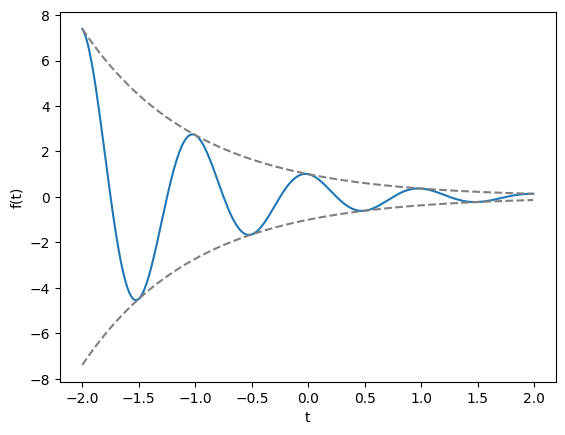

In [ ]:
t = np.arange(-2,2,0.01)
f = np.exp(-t) * np.cos(2*np.pi*t)

plt.plot(t, f)
plt.plot(t, np.exp(-t), '--', color='gray')
plt.plot(t, -np.exp(-t), '--', color='gray')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.show()

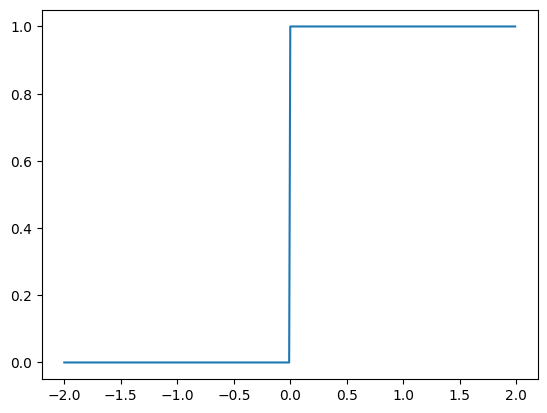

In [ ]:
deg = (t>=0)*1 # multiplicar por 1 é opcional pois o resultado de t>=0 já retorna 1

plt.plot(t,deg)
plt.show()

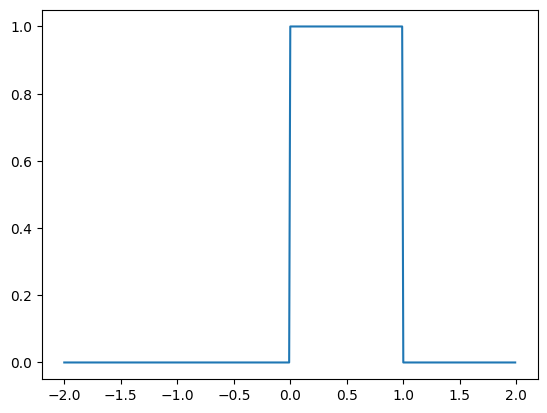

In [ ]:
p = []
for i in t:
  p.append(1 if i >=0 and i < 1 else 0)

plt.plot(t, p)
plt.show()

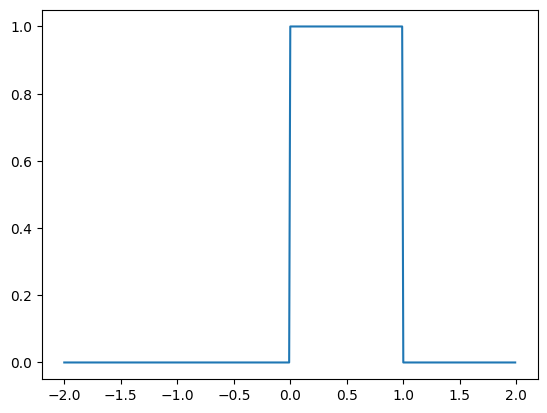

In [ ]:
ut = (t>=0)*1
ut1 = (t>=1)*1
p = ut - ut1

plt.plot(t,p)
plt.show()

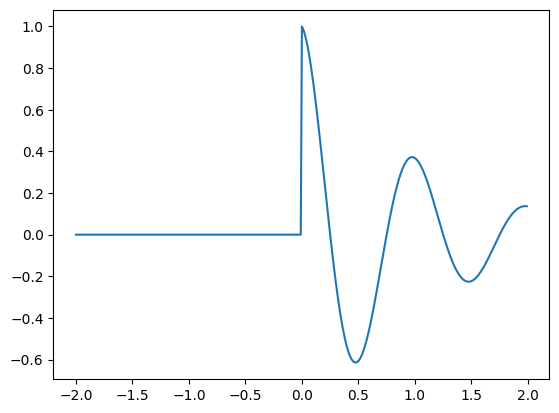

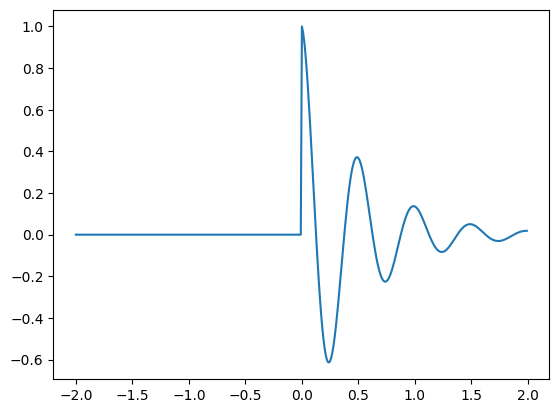

In [ ]:
gt = f * ut
g2t1 = np.exp(-2*t) * np.cos(2*np.pi*2*t) * ut

plt.plot(t,gt)
plt.show()
plt.plot(t,g2t1)
plt.show()